Import required packages

In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from geopy import distance
import folium
import requests
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Import Foursquare credentials from json file created to preserve secrecy and store in global variables CLIENT_ID and CLIENT_SECRET

In [2]:
import json
globals().update(json.loads(open("foursquareCredentials.json", "r") .read()))
VERSION = '20181124' # Foursquare API version

## Input the variables that define the problem
Get longitude and latitude of location where we want to open a new business

In [3]:
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.geocode("Rumbach Sebestyén u., Budapest, 1075 Hungary")
#location = geolocator.geocode("Galley Ave, Toronto")
#location = geolocator.geocode("st dunstans st, canterbury uk")
lat = location.latitude
long = location.longitude

Populate variables containing the other parameters of the search problem:
* categoryId = foursquare categoryId of the business we wish to open. A full list of categories can be found here: https://developer.foursquare.com/docs/resources/categories.
* radius = the maximum distance from the location within which we want to open the business in km.
* tick = the level of accuracy in km which we want to return for the recommended locations. 

In [4]:
categoryId = '4bf58dd8d48988d16d941735' # Café
radius = 2
tick = 0.2

## Build grid of points within radius of location
Define function degreeLen which for a given lat and long returns the length of a degree of lat and long in km

In [5]:
def degreeLen(lat, long):
    """Returns the lengths of a single degree of latitude and longitude in km for a given latitude and longitude
    """
    # get length of 1 degree at current latidude and logitude
    latDegree = distance.distance((lat - 0.5, long), (lat + 0.5, long)).km
    longDegree = distance.distance((lat, long - 0.5), (lat, long + 0.5)).km
    return latDegree, longDegree
degreeLen(lat, long)

(111.18052869040775, 75.34729533841742)

Define function grid that returns the set of grid points within a circle around location.  Grid points are a distance tick apart.

In [6]:
def grid(lat, long, radius, tick):
    """Returns a set whose elements are a grid of points within a circle around a location
    :param lat: latitude of centre of grid
    :param long: longitude of centre of grid
    :param radius: radius of grid in km
    :param tick: distance between points in grid in km
    """
    # get length of 1 degree at current latidude and logitude
    latDegree, longDegree = degreeLen(lat, long)
    
    # get length of 1 tick in degrees
    latTick = tick / latDegree
    longTick = tick / longDegree
    
    # get coordinates of point which is one radius to the South and West of (lat, long)
    bottomLeft = (lat - radius / latDegree, long - radius / longDegree)
    
    # get tick points along axis
    gridLats = np.arange(2 * radius / tick + 1) * latTick + bottomLeft[0]
    gridLongs = np.arange(2 * radius / tick + 1) * longTick + bottomLeft[1]
    
    # create the set grid made up of points within radius of lat, long, disance tick apart 
    grid = {(lt, lg) for lt in gridLats for lg in gridLongs if distance.distance((lat, long), (lt, lg)).km <= radius}
    
    return grid

Check grid function is working using Folium

In [7]:
g = grid(lat, long, radius, tick)
# create map
map_grid = folium.Map(location=[lat, long], zoom_start=13)

for (lt, lg) in g:
    folium.CircleMarker([lt, lg],
                        radius=2,
                        fill=True,
                        fill_opacity=0.5).add_to(map_grid)
print("Number of points in grid = " + str(len(g)))      
map_grid

Number of points in grid = 310


## Build function which pulls venue data from Foursquare
Define function for pulling list of nearby venues, with optional filter on category Id

In [8]:
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&intent=browse&ll={},{}&radius={}&categoryId={}'
def getNearbyVenues(lat, long, radius, categoryId = ''):
    apiCall = url.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, long, radius, categoryId)
    venues = requests.get(apiCall).json()['response']['venues']
    venues_list=[]
    
    for v in venues:
        if len(v['categories']) > 0:
            venues_list.append([v['id'], v['name'], v['location']['lat'], v['location']['lng'],
                                v['location']['distance'], v['categories'][0]['name']])
        else:
            venues_list.append([v['id'], v['name'], v['location']['lat'], v['location']['lng'],
                                v['location']['distance'], 'None'])
    
    return(venues_list)

Check function getNearbyVenues is working

In [9]:
getNearbyVenues(lat, long, tick * 1000, categoryId)

[['510c25ede4b0a3ee4308e94a',
  'Központ',
  47.49803248645761,
  19.05786765554933,
  188,
  'Café'],
 ['4c9ce18c542b224bbaade49f',
  'Drum Cafe',
  47.496305854615436,
  19.059092795797216,
  100,
  'Café'],
 ['52054dd511d2778ebd4f1cf3',
  'Blue Bird Cafe',
  47.498517,
  19.059294,
  171,
  'Café'],
 ['514d9e95e4b01bb2769654a3', 'Solinfo', 47.496772, 19.060707, 67, 'Café'],
 ['4c8e63f5a8de224be0182701',
  'Café Vian',
  47.49859092984949,
  19.05913427325024,
  182,
  'French Restaurant'],
 ['5b9a6c1d1ffe97002c3349c7',
  'Fresh Corner Downtown',
  47.496753,
  19.057435,
  187,
  'Café'],
 ['54535798498ef0cd9c592e6e',
  'Blue Bird Roastery',
  47.49777829728421,
  19.058437609053712,
  137,
  'Café'],
 ['4b804281f964a520d36130e3',
  'Spinoza Café',
  47.497600443427714,
  19.06069457530975,
  87,
  'Restaurant'],
 ['4b99441cf964a520be6e35e3',
  'Printa Café',
  47.49761850364259,
  19.058682060571808,
  111,
  'Art Gallery'],
 ['5152e6f0e4b02b6799b2ef78',
  'Tom Dixon Cafè & Showroo

## Build function to calculate density of venues within a specified radius of a location
Define function venueDensity which outputs a measure the density of a list of venues within a specific radius of a location.
The density measure has the property of being larger the more venues there are in the list and the closer they are.
So for each venue we subtract the distance of the venue from the location from the radius.
This measure is then summed up for all the venues

Worked example, radius = 200m, 2 venues, 1 distance 1m from the location, the other distance 199m:
* venue 1 density = 200 - 1 = 199
* venue 2 density = 200 - 199 = 1
* total density = 199 + 1 = 200

In [10]:
def venueDensity(venues, radius):
    distances = []
    [distances.append(radius - v[4]) for v in venues if v[4] < radius]
    return np.sum(np.asarray(distances))

In [11]:
venueDensity(getNearbyVenues(lat, long, tick * 1000, categoryId), tick * 1000)

1635.0

In [12]:
# Check if density for empty list of venues = 0
venueDensity([], tick * 1000)

0.0

## Get venue density for each point on the grid around location

In [13]:
densities = []
ids = set()
for (lt, lg) in g:
    print((lt, lg))
    venues = getNearbyVenues(lt, lg, tick * 1000, categoryId)
    density = venueDensity(venues, tick * 1000)
    densities.append((lt, lg, density))
    for (v_id, name, vlt, vlg, distance, category) in venues:
        ids.add(v_id)

(47.498829676137355, 19.078470527130836)
(47.50422630454943, 19.062544275304408)
(47.49343304772528, 19.03600052226036)
(47.4970308, 19.067853025913216)
(47.50242742841207, 19.03865489756476)
(47.50242742841207, 19.065198650608814)
(47.491634171587926, 19.041309272869167)
(47.4970308, 19.057235524695596)
(47.4970308, 19.083779277739648)
(47.506025180686784, 19.054581149391193)
(47.511421809098856, 19.070507401217622)
(47.50242742841207, 19.0598899)
(47.50782405682414, 19.043963648173573)
(47.51322068523621, 19.065198650608814)
(47.48983529545056, 19.083779277739648)
(47.498829676137355, 19.04927239878238)
(47.50782405682414, 19.04661802347798)
(47.51322068523621, 19.062544275304408)
(47.47904203862642, 19.0598899)
(47.491634171587926, 19.067853025913216)
(47.49343304772528, 19.03865489756476)
(47.49343304772528, 19.065198650608814)
(47.50242742841207, 19.03600052226036)
(47.506025180686784, 19.081124902435242)
(47.50782405682414, 19.051926774086787)
(47.49523192386264, 19.0705074012176

(47.50062855227471, 19.083779277739648)
(47.48443866703849, 19.051926774086787)
(47.491634171587926, 19.073161776522028)
(47.4970308, 19.043963648173573)
(47.50422630454943, 19.03600052226036)
(47.506025180686784, 19.0598899)
(47.50782405682414, 19.073161776522028)
(47.488036419313204, 19.041309272869167)
(47.49523192386264, 19.04927239878238)
(47.50062855227471, 19.078470527130836)
(47.5096229329615, 19.062544275304408)
(47.511421809098856, 19.04661802347798)
(47.48263979090113, 19.0598899)
(47.488036419313204, 19.07581615182643)
(47.49523192386264, 19.067853025913216)
(47.498829676137355, 19.03600052226036)
(47.50422630454943, 19.051926774086787)
(47.48443866703849, 19.078470527130836)
(47.48983529545056, 19.04927239878238)
(47.498829676137355, 19.057235524695596)
(47.498829676137355, 19.083779277739648)
(47.50422630454943, 19.054581149391193)
(47.51322068523621, 19.070507401217622)
(47.48983529545056, 19.065198650608814)
(47.48983529545056, 19.03865489756476)
(47.49523192386264, 19.

In [14]:
densitiesDf = pd.DataFrame(densities)
densitiesDf.columns = ['Latitude', 'Longitude', 'Density']
densitiesDf.set_index(['Latitude', 'Longitude'], inplace=True)
densitiesDf.sort_index(inplace=True)
densitiesDf

Density
Latitude  Longitude         
47.479042 19.059890      0.0
47.480841 19.049272     59.0
          19.051927    800.0
          19.054581    499.0
          19.057236     55.0
          19.059890      0.0
          19.062544      0.0
          19.065199    325.0
          19.067853    298.0
          19.070507    937.0
47.482640 19.046618      0.0
          19.049272      0.0
          19.051927    693.0
          19.054581    612.0
          19.057236     20.0
          19.059890    112.0
          19.062544     25.0
          19.065199    109.0
          19.067853    433.0
          19.070507    768.0
          19.073162    571.0
47.484439 19.041309      0.0
          19.043964      0.0
          19.046618      0.0
          19.049272      0.0
          19.051927     74.0
          19.054581     83.0
          19.057236      0.0
          19.059890    969.0
          19.062544    594.0
...                      ...
47.509623 19.059890    223.0
          19.062544    366.0
          19.065199    192.0
          19.067853    555.0
          19.070507    192.0
          19.073162     23.0
          19.075816      0.0
          19.078471     48.0
47.511422 19.043964      0.0
          19.046618    189.0
          19.049272    288.0
          19.051927    868.0
          19.054581    453.0
          19.057236   1155.0
          19.059890    375.0
          19.062544    399.0
          19.065199    109.0
          19.067853    253.0
          19.070507    126.0
          19.073162    260.0
          19.075816     30.0
47.513221 19.049272    769.0
          19.051927    569.0
          19.054581    432.0
          19.057236   2217.0
          19.059890   2296.0
          19.062544     39.0
          19.065199      0.0
          19.067853      0.0
          19.070507      9.0

[310 rows x 1 columns]

In [15]:
densitiesDf.describe()

,Density
count,310.000000
mean,418.841935
std,446.560488
min,0.000000
25%,69.500000
50%,266.500000
75%,669.500000
max,2296.000000


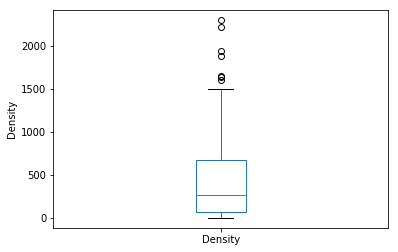

In [16]:
densitiesDf.plot(y='Density', kind='box')
plt.ylabel('Density')
plt.show()

In [17]:
densitiesDf['Log Density'] = np.log10(densitiesDf['Density'].values + 1)

In [18]:
densitiesDf.describe()

,Density,Log Density
count,310.000000,310.000000
mean,418.841935,2.125382
std,446.560488,0.957504
min,0.000000,0.000000
25%,69.500000,1.848157
50%,266.500000,2.427287
75%,669.500000,2.826396
max,2296.000000,3.361161


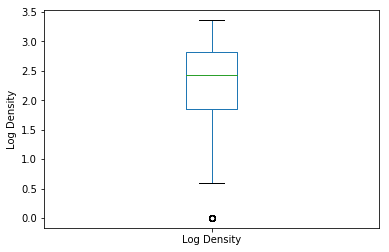

In [19]:
densitiesDf.plot(y='Log Density', kind='box')
plt.ylabel('Log Density')
plt.show()

In [20]:
ids

{'4b405e24f964a520e1b725e3',
 '4b45eee3f964a520821226e3',
 '4b4fb933f964a520a41227e3',
 '4b52bdaef964a520328727e3',
 '4b559b58f964a520d2e827e3',
 '4b561c01f964a520d00028e3',
 '4b66f242f964a520a7312be3',
 '4b68a5d2f964a520be842be3',
 '4b69bf00f964a52085b12be3',
 '4b69c896f964a520f8b32be3',
 '4b6af49df964a520cae82be3',
 '4b76ff93f964a520e7722ee3',
 '4b782fcbf964a520b8ba2ee3',
 '4b7e8a1af964a520bcf12fe3',
 '4b7f05e8f964a520051130e3',
 '4b804281f964a520d36130e3',
 '4b82aa9af964a52052dd30e3',
 '4b83b33cf964a520670d31e3',
 '4b85b1e3f964a5205f6d31e3',
 '4b99441cf964a520be6e35e3',
 '4b9b6c79f964a520730636e3',
 '4b9fa2e8f964a520803037e3',
 '4ba15a89f964a5206baf37e3',
 '4ba1e53ff964a520efd037e3',
 '4ba4b1b7f964a520e0ac38e3',
 '4ba644eaf964a520ec4039e3',
 '4ba74045f964a520f38739e3',
 '4bab8db2f964a5200ab33ae3',
 '4bb2507d14cfd13a47c514ab',
 '4bb354612397b713b1f137b3',
 '4bb4d546bc82a593ade83e72',
 '4bbadceeb35776b08763cb01',
 '4bbf46e898f49521ef56d263',
 '4bbf610a006dc9b6377afc3f',
 '4bbf8d8aabf4

In [21]:
otherVenues = []
for (lt, lg) in g:
    print((lt, lg))
    venues = getNearbyVenues(lt, lg, tick * 1000)
    for (v_id, name, vlt, vlg, distance, category) in venues:
        if not (v_id in ids) and category != 'None' and distance < tick * 1000 :
            otherVenues.append((lt, lg, v_id, name, vlt, vlg, distance, category))

(47.498829676137355, 19.078470527130836)
(47.50422630454943, 19.062544275304408)
(47.49343304772528, 19.03600052226036)
(47.4970308, 19.067853025913216)
(47.50242742841207, 19.03865489756476)
(47.50242742841207, 19.065198650608814)
(47.491634171587926, 19.041309272869167)
(47.4970308, 19.057235524695596)
(47.4970308, 19.083779277739648)
(47.506025180686784, 19.054581149391193)
(47.511421809098856, 19.070507401217622)
(47.50242742841207, 19.0598899)
(47.50782405682414, 19.043963648173573)
(47.51322068523621, 19.065198650608814)
(47.48983529545056, 19.083779277739648)
(47.498829676137355, 19.04927239878238)
(47.50782405682414, 19.04661802347798)
(47.51322068523621, 19.062544275304408)
(47.47904203862642, 19.0598899)
(47.491634171587926, 19.067853025913216)
(47.49343304772528, 19.03865489756476)
(47.49343304772528, 19.065198650608814)
(47.50242742841207, 19.03600052226036)
(47.506025180686784, 19.081124902435242)
(47.50782405682414, 19.051926774086787)
(47.49523192386264, 19.0705074012176

(47.50062855227471, 19.083779277739648)
(47.48443866703849, 19.051926774086787)
(47.491634171587926, 19.073161776522028)
(47.4970308, 19.043963648173573)
(47.50422630454943, 19.03600052226036)
(47.506025180686784, 19.0598899)
(47.50782405682414, 19.073161776522028)
(47.488036419313204, 19.041309272869167)
(47.49523192386264, 19.04927239878238)
(47.50062855227471, 19.078470527130836)
(47.5096229329615, 19.062544275304408)
(47.511421809098856, 19.04661802347798)
(47.48263979090113, 19.0598899)
(47.488036419313204, 19.07581615182643)
(47.49523192386264, 19.067853025913216)
(47.498829676137355, 19.03600052226036)
(47.50422630454943, 19.051926774086787)
(47.48443866703849, 19.078470527130836)
(47.48983529545056, 19.04927239878238)
(47.498829676137355, 19.057235524695596)
(47.498829676137355, 19.083779277739648)
(47.50422630454943, 19.054581149391193)
(47.51322068523621, 19.070507401217622)
(47.48983529545056, 19.065198650608814)
(47.48983529545056, 19.03865489756476)
(47.49523192386264, 19.

In [23]:
otherVenuesDf = pd.DataFrame(otherVenues)
otherVenuesDf.columns = ['Latitude', 'Longitude', 'VenueID', 'Name', 'VenueLat', 'VenueLong', 'Distance', 'Category']
otherVenuesDf.set_index(['Latitude', 'Longitude'], inplace=True)
otherVenuesDf.sort_index(inplace=True)
otherVenuesDf

VenueID  \
Latitude  Longitude                             
47.479042 19.059890  4ba8e306f964a5202cf739e3   
          19.059890  4f059727d3e321b78f7a6655   
          19.059890  4e08adaaa809495e61a017a8   
          19.059890  5669bf30498e50a39729c6de   
          19.059890  511a3517e4b0d096c320ede9   
          19.059890  4d09d878ddb8f04dfb9e30aa   
          19.059890  4fcef568e4b0b4dd488d5295   
          19.059890  4ba8e9eff964a52097f939e3   
          19.059890  526513c8498e22282fd037a2   
          19.059890  4ea694f07ee5bebc94b27a20   
          19.059890  5240014f11d29e0419c1077b   
          19.059890  4ba8ebeaf964a52058fa39e3   
          19.059890  582ed5e00b5656378a87d099   
          19.059890  52fcbf52498e5a3089ed1df9   
          19.059890  51b86e3e498e2a70c2f4930e   
          19.059890  507575ebe4b01d2c3d4b03a3   
          19.059890  5139e6afe4b0257b60e03cda   
          19.059890  508bf7b1e4b0a1c8476fff2d   
          19.059890  506182fae4b008c57d902a7c   
          19.059890  4e4976c31fc7a73d0db38fcd   
          19.059890  4ca8fb87965c9c74a1eac9fa   
          19.059890  545b5c76498ee6fdb442ad29   
          19.059890  4f44c1c8e4b0f1d45d1efbcb   
          19.059890  576ce61c498e72c8c4d7935e   
          19.059890  5703ab49498e54b9c6689c1f   
          19.059890  4f38e491e4b0d408a5eda9e2   
          19.059890  53a038a7498e08a9de3e2fad   
          19.059890  4f0c073de4b02df3eba43981   
47.480841 19.049272  5052f626e4b0244ddd45931b   
          19.049272  4d62670229ef236aa470bb59   
...                                       ...   
47.513221 19.067853  50a8df32e4b05407c2efec32   
          19.067853  56251641498e15059a17199f   
          19.067853  5a15dc72a92d985d52d55215   
          19.070507  4d2daf8baa5c6ea8cd39af04   
          19.070507  4c8a42021eafb1f7d6787835   
          19.070507  5868151cca10703aaabe71a2   
          19.070507  5b7562651953f3002c045a98   
          19.070507  4e8eb3c9b8f7c08295aa22b8   
          19.070507  59d4bf8a67af3a1571dbab7d   
          19.070507  4ea04dca722e575b9ed40d86   
          19.070507  593d1b82088158548cf02b4f   
          19.070507  56dc5c4d498e9bfed83e5a9a   
          19.070507  53442630498eb143ea755472   
          19.070507  53b80580498e041871fa8844   
          19.070507  564f4887498e9cd06b7e9ad6   
          19.070507  4e9717dd93ad7ae7cd49e22d   
          19.070507  4e6efb1f8998fd5c566ace68   
          19.070507  5898a0cf1e1de501d968c097   
          19.070507  4ce02f7570bba1cd98e06ac4   
          19.070507  4eb39d5293ad23656f5c6875   
          19.070507  4d7b5eb4645ea35d55b930f8   
          19.070507  536620ec498e7186ef609364   
          19.070507  4f9cfaf2e4b060916940d353   
          19.070507  4d090fc184ec224b7cfd2c62   
          19.070507  51c5e112498e71cc06b3e27e   
          19.070507  519e3ce4498ec1672c4049dc   
          19.070507  590845f29e0d541198c42483   
          19.070507  568136ed498ea93425014978   
          19.070507  4e68976462e1a02a61143102   
          19.070507  576fc39c498e9e879e5071e3   

                                                                  Name  \
Latitude  Longitude                                                      
47.479042 19.059890                                       BME R épület   
          19.059890                    BME Központi Tanulmányi Hivatal   
          19.059890                   Valdemar és Nina Langlet rakpart   
          19.059890                   Műegyetemi Református Lelkészség   
          19.059890                                            BME R4D   
          19.059890                    BME Nukleáris Technikai Intézet   
          19.059890                                           BME R108   
          19.059890                                       BME T épület   
          19.059890                   Hardbodyhang Street Workout Park   
          19.059890                   BME Hallgatói Számítógép Központ   
          19.059890                                           

In [24]:
otherVenuesDf['Density'] = (tick * 1000) - otherVenuesDf['Distance']
otherVenuesDf

VenueID  \
Latitude  Longitude                             
47.479042 19.059890  4ba8e306f964a5202cf739e3   
          19.059890  4f059727d3e321b78f7a6655   
          19.059890  4e08adaaa809495e61a017a8   
          19.059890  5669bf30498e50a39729c6de   
          19.059890  511a3517e4b0d096c320ede9   
          19.059890  4d09d878ddb8f04dfb9e30aa   
          19.059890  4fcef568e4b0b4dd488d5295   
          19.059890  4ba8e9eff964a52097f939e3   
          19.059890  526513c8498e22282fd037a2   
          19.059890  4ea694f07ee5bebc94b27a20   
          19.059890  5240014f11d29e0419c1077b   
          19.059890  4ba8ebeaf964a52058fa39e3   
          19.059890  582ed5e00b5656378a87d099   
          19.059890  52fcbf52498e5a3089ed1df9   
          19.059890  51b86e3e498e2a70c2f4930e   
          19.059890  507575ebe4b01d2c3d4b03a3   
          19.059890  5139e6afe4b0257b60e03cda   
          19.059890  508bf7b1e4b0a1c8476fff2d   
          19.059890  506182fae4b008c57d902a7c   
          19.059890  4e4976c31fc7a73d0db38fcd   
          19.059890  4ca8fb87965c9c74a1eac9fa   
          19.059890  545b5c76498ee6fdb442ad29   
          19.059890  4f44c1c8e4b0f1d45d1efbcb   
          19.059890  576ce61c498e72c8c4d7935e   
          19.059890  5703ab49498e54b9c6689c1f   
          19.059890  4f38e491e4b0d408a5eda9e2   
          19.059890  53a038a7498e08a9de3e2fad   
          19.059890  4f0c073de4b02df3eba43981   
47.480841 19.049272  5052f626e4b0244ddd45931b   
          19.049272  4d62670229ef236aa470bb59   
...                                       ...   
47.513221 19.067853  50a8df32e4b05407c2efec32   
          19.067853  56251641498e15059a17199f   
          19.067853  5a15dc72a92d985d52d55215   
          19.070507  4d2daf8baa5c6ea8cd39af04   
          19.070507  4c8a42021eafb1f7d6787835   
          19.070507  5868151cca10703aaabe71a2   
          19.070507  5b7562651953f3002c045a98   
          19.070507  4e8eb3c9b8f7c08295aa22b8   
          19.070507  59d4bf8a67af3a1571dbab7d   
          19.070507  4ea04dca722e575b9ed40d86   
          19.070507  593d1b82088158548cf02b4f   
          19.070507  56dc5c4d498e9bfed83e5a9a   
          19.070507  53442630498eb143ea755472   
          19.070507  53b80580498e041871fa8844   
          19.070507  564f4887498e9cd06b7e9ad6   
          19.070507  4e9717dd93ad7ae7cd49e22d   
          19.070507  4e6efb1f8998fd5c566ace68   
          19.070507  5898a0cf1e1de501d968c097   
          19.070507  4ce02f7570bba1cd98e06ac4   
          19.070507  4eb39d5293ad23656f5c6875   
          19.070507  4d7b5eb4645ea35d55b930f8   
          19.070507  536620ec498e7186ef609364   
          19.070507  4f9cfaf2e4b060916940d353   
          19.070507  4d090fc184ec224b7cfd2c62   
          19.070507  51c5e112498e71cc06b3e27e   
          19.070507  519e3ce4498ec1672c4049dc   
          19.070507  590845f29e0d541198c42483   
          19.070507  568136ed498ea93425014978   
          19.070507  4e68976462e1a02a61143102   
          19.070507  576fc39c498e9e879e5071e3   

                                                                  Name  \
Latitude  Longitude                                                      
47.479042 19.059890                                       BME R épület   
          19.059890                    BME Központi Tanulmányi Hivatal   
          19.059890                   Valdemar és Nina Langlet rakpart   
          19.059890                   Műegyetemi Református Lelkészség   
          19.059890                                            BME R4D   
          19.059890                    BME Nukleáris Technikai Intézet   
          19.059890                                           BME R108   
          19.059890                                       BME T épület   
          19.059890                   Hardbodyhang Street Workout Park   
          19.059890                   BME Hallgatói Számítógép Központ   
          19.059890                                           

In [25]:
features = pd.pivot_table(otherVenuesDf,index=['Latitude', 'Longitude'],values='Density',
                          columns='Category',aggfunc=[np.sum],fill_value=0)['sum']

In [26]:
features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 310 entries, (47.47904203862642, 19.0598899) to (47.51322068523621, 19.070507401217622)
Columns: 492 entries, ATM to Zoo Exhibit
dtypes: int64(492)
memory usage: 1.2 MB


In [27]:
features

Category             ATM  Accessories Store  Adult Boutique  \
Latitude  Longitude                                           
47.479042 19.059890    0                  0               0   
47.480841 19.049272    0                  0               0   
          19.051927    0                  0               0   
          19.054581    0                  0               0   
          19.057236    0                  0               0   
          19.059890    0                  0               0   
          19.062544    0                  0               0   
          19.065199    0                  0               0   
          19.067853    0                  0               0   
          19.070507    0                  0               0   
47.482640 19.046618    0                  0               0   
          19.049272    0                  0               0   
          19.051927    0                  0               0   
          19.054581    0                  0               0   
          19.057236    0                  0               0   
          19.059890    0                  0               0   
          19.062544    0                  0               0   
          19.065199    0                  0               0   
          19.067853    0                  0             132   
          19.070507    0                  0               0   
          19.073162    0                  0               0   
47.484439 19.041309    0                  0               0   
          19.043964    0                  0               0   
          19.046618    0                  0               0   
          19.049272    0                  0               0   
          19.051927    0                  0               0   
          19.054581    0                  0               0   
          19.057236    0                  0               0   
          19.059890    0                  0               0   
          19.062544    0                  0               0   
...                  ...                ...             ...   
47.509623 19.059890    0                  0               0   
          19.062544    0                  0               0   
          19.065199    0                175               0   
          19.067853    0                  0               0   
          19.070507    0                  0               0   
          19.073162    0                  0               0   
          19.075816    0                  0               0   
          19.078471    0                  0               0   
47.511422 19.043964    0                  0               0   
          19.046618    0                  0               0   
          19.049272    0                  0               0   
          19.051927    0                  0               0   
          19.054581    0                  0               0   
          19.057236    0                  0               0   
          19.059890    0                  0               0   
          19.062544    0                  0               0   
          19.065199    0                  0               0   
          19.067853    0                  0               0   
          19.070507    0                  0               0   
          19.073162    0                  0               0   
          19.075816    0                  0               0   
47.513221 19.049272    0                  0               0   
          19.051927    0                  0               0   
          19.054581    0                  0               0   
          19.057236    0                106               0   
          19.059890    0                  0               0   
          19.062544    0                  0               0   
          19.065199    0                  0               0   
          19.067853    0                  0               0   
          19.070507    0                  0               0   

Category             Advertisi

In [28]:
features.describe()

Category,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Alternative Healer,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Waterfall,Waterfront,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo Exhibit
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,...,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,0.529032,7.045161,2.735484,4.987097,1.025806,1.241935,0.964516,0.648387,0.903226,6.419355,...,0.490323,0.938710,0.193548,1.635484,15.532258,5.745161,7.648387,11.980645,9.419355,0.664516
std,6.671496,32.294627,19.828578,30.754901,12.872765,12.831098,11.188964,8.296815,11.450625,29.495515,...,8.633020,9.425545,2.728483,13.483036,43.885006,26.667245,32.179446,47.940291,41.273164,7.434092
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,96.000000,259.000000,179.000000,333.000000,181.000000,181.000000,164.000000,125.000000,168.000000,247.000000,...,152.000000,108.000000,46.000000,133.000000,248.000000,174.000000,267.000000,353.000000,350.000000,103.000000


In [29]:
features = np.log10(features + 1)

In [30]:
features.describe()

Category,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Alternative Healer,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Waterfall,Waterfront,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo Exhibit
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,...,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,0.012341,0.108675,0.041537,0.067665,0.014193,0.024186,0.018464,0.012861,0.013810,0.107860,...,0.007047,0.022149,0.009188,0.031906,0.262702,0.106399,0.139946,0.155566,0.129381,0.017227
std,0.153507,0.468387,0.296348,0.376748,0.176486,0.215480,0.189633,0.160088,0.171793,0.460313,...,0.124082,0.200585,0.115931,0.250663,0.688864,0.448608,0.511146,0.565723,0.513354,0.176309
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.986772,2.414973,2.255273,2.523746,2.260071,2.260071,2.217484,2.100371,2.227887,2.394452,...,2.184691,2.037426,1.672098,2.127105,2.396199,2.243038,2.428135,2.549003,2.545307,2.017033


In [31]:
features = features.join(densitiesDf).fillna(0).reset_index()

In [32]:
features.describe()

,Latitude,Longitude,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Alternative Healer,American Restaurant,Amphitheater,...,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo Exhibit,Density,Log Density
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,...,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,47.497135,19.059890,0.012341,0.108675,0.041537,0.067665,0.014193,0.024186,0.018464,0.012861,...,0.009188,0.031906,0.262702,0.106399,0.139946,0.155566,0.129381,0.017227,418.841935,2.125382
std,0.008983,0.013169,0.153507,0.468387,0.296348,0.376748,0.176486,0.215480,0.189633,0.160088,...,0.115931,0.250663,0.688864,0.448608,0.511146,0.565723,0.513354,0.176309,446.560488,0.957504
min,47.479042,19.036001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.489835,19.049272,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.500000,1.848157
50%,47.497031,19.059890,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,266.500000,2.427287
75%,47.504226,19.070507,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,669.500000,2.826396
max,47.513221,19.083779,1.986772,2.414973,2.255273,2.523746,2.260071,2.260071,2.217484,2.100371,...,1.672098,2.127105,2.396199,2.243038,2.428135,2.549003,2.545307,2.017033,2296.000000,3.361161


In [33]:
X = features.drop(['Latitude', 'Longitude', 'Density', 'Log Density'], axis=1)
y = features['Log Density']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=22)

In [35]:
reg_all = linear_model.LinearRegression()
reg_all.fit(X_train, y_train)
y_pred_test = reg_all.predict(X_test)
y_pred_train = reg_all.predict(X_train)
reg_all.score(X_test, y_test)

-0.1628207165432578

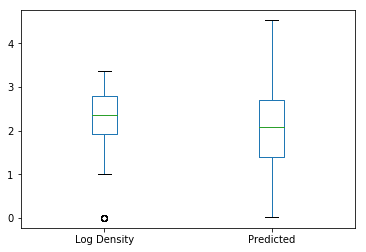

In [36]:
testDf = y_test.to_frame()
testDf['Predicted'] = y_pred_test
testDf.plot(kind='box')
plt.show()

In [37]:
testDf.describe()

,Log Density,Predicted
count,93.000000,93.000000
mean,2.159009,2.079090
std,0.892550,0.940506
min,0.000000,0.014110
25%,1.924279,1.401441
50%,2.352183,2.091637
75%,2.787460,2.710113
max,3.361161,4.526958


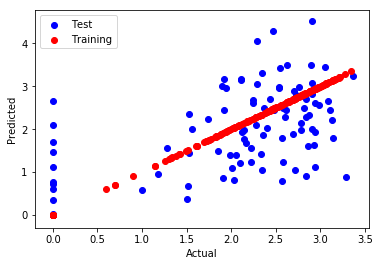

In [38]:
plt.scatter(y_test, y_pred_test, color='blue', label='Test')
plt.scatter(y_train, y_pred_train, color='red', label='Training')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend(loc='upper left')
plt.show()

In [39]:
lasso = linear_model.Lasso(alpha=0.005, normalize=True)
lasso.fit(X_train, y_train)
lasso_pred_test = lasso.predict(X_test)
lasso_pred_train = lasso.predict(X_train)
lasso.score(X_test, y_test)

0.3422508932059716

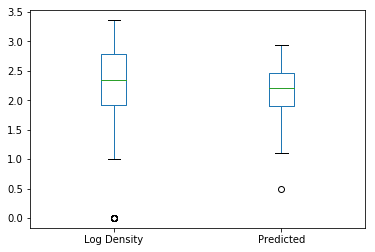

In [40]:
testDf = y_test.to_frame()
testDf['Predicted'] = lasso_pred_test
testDf.plot(kind='box')
plt.show()

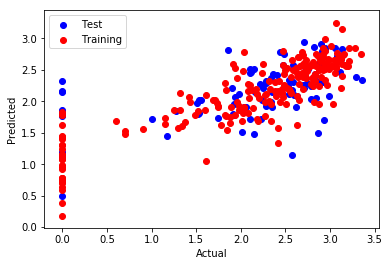

In [41]:
plt.scatter(y_test, lasso_pred_test, color='blue', label='Test')
plt.scatter(y_train, lasso_pred_train, color='red', label='Training')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend(loc='upper left')
plt.show()

In [42]:
lasso_pred_all = lasso.predict(X)

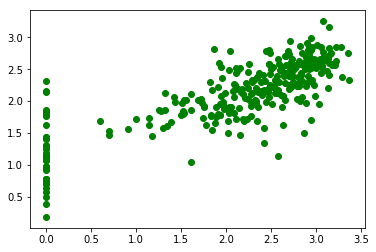

In [43]:
plt.scatter(y, lasso_pred_all, color='green')
plt.show()

In [44]:
len(lasso_pred_all)

310

In [45]:
results = features[['Latitude', 'Longitude', 'Log Density']]

In [46]:
results['Predicted'] = lasso_pred_all

C:\Users\mattc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


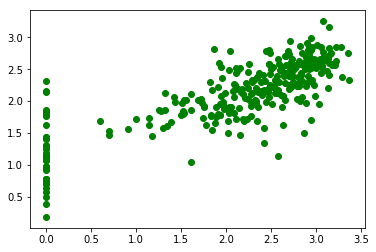

In [47]:
plt.scatter(results['Log Density'], results['Predicted'], color='green')
plt.show()

In [48]:
results['Rank'] = results['Predicted'] / (results['Log Density'] + 1)

C:\Users\mattc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [49]:
top10 = results.sort_values(by='Rank', ascending=False).head(10)
top10

,Latitude,Longitude,Log Density,Predicted,Rank
257,47.507824,19.041309,0.0,2.318799,2.318799
50,47.486238,19.078471,0.0,2.161927,2.161927
124,47.493433,19.083779,0.0,2.141921,2.141921
222,47.504226,19.041309,0.0,1.863646,1.863646
35,47.484439,19.078471,0.0,1.826566,1.826566
223,47.504226,19.043964,0.0,1.815262,1.815262
6,47.480841,19.062544,0.0,1.789876,1.789876
5,47.480841,19.059890,0.0,1.781363,1.781363
288,47.511422,19.043964,0.0,1.771409,1.771409
27,47.484439,19.057236,0.0,1.620367,1.620367


In [50]:
l = list(zip(top10['Latitude'], top10['Longitude']))
l

[(47.50782405682414, 19.041309272869167),
 (47.48623754317585, 19.078470527130836),
 (47.49343304772528, 19.083779277739648),
 (47.50422630454943, 19.041309272869167),
 (47.48443866703849, 19.078470527130836),
 (47.50422630454943, 19.043963648173573),
 (47.480840914763775, 19.062544275304408),
 (47.480840914763775, 19.0598899),
 (47.511421809098856, 19.043963648173573),
 (47.48443866703849, 19.057235524695596)]

In [51]:
# create map
map_grid = folium.Map(location=[lat, long], zoom_start=13)

for (lt, lg) in l:
    folium.CircleMarker([lt, lg],
                        radius=4,
                        fill=True,
                        fill_opacity=0.5,
                        color='Red').add_to(map_grid)
       
map_grid